In [1]:
import pymannkendall as mk
import os
import numpy as np
from netCDF4 import Dataset, num2date

In [2]:

data_dir = '../../results/Modis/chla/'
varname = 'chlor_a'
cmin, cmax = 10, 30  # Set the min and max values for the color scale
# Initialize a dictionary to hold the data for each month.
# Assuming these are the coordinates you want to crop to

# lat_min_crop, lat_max_crop = 34.3, 35.7  # Update these values as needed
# lon_min_crop, lon_max_crop = 138.3, 140.23  # Update these values as needed

lat_min_crop, lat_max_crop = 34.5, 35.4
lon_min_crop, lon_max_crop = 138.9, 139.9

# lat_min_crop, lat_max_crop = 34.4, 35.7
# lon_min_crop, lon_max_crop = 138.35, 140.2


In [28]:

# Prepare an array to store time series data for each pixel
time_series_data = {}
time_series_data_winter = {}
time_series_data_spring = {}
time_series_data_summer = {}
time_series_data_autumn = {}

file_dates = []
count = 0
# seasonal_data = {"spring":{}, "summer":{}, "autumn":{}, "winter":{}},
  
# Loop through files and collect time series data for each pixel
for file_name in sorted(os.listdir(data_dir)):
    if file_name.endswith('.nc'):
        count = count +1
        year, month = int(file_name[1:5]), int(file_name[5:7])  # Modis
        # year, month = int(file_name[2:6]), int(file_name[6:8])   # GCOMC
        # print(year, month)
        if year < 2003 or year > 2022:
            continue
 
        file_path = os.path.join(data_dir, file_name)
        with Dataset(file_path, 'r') as nc:
            lat = nc['lat'][:]
            lon = nc['lon'][:]
            sst = np.ma.squeeze(nc[varname][:])

            # Find indices for cropping
            lat_inds = np.where((lat >= lat_min_crop) & (lat <= lat_max_crop))[0]
            lon_inds = np.where((lon >= lon_min_crop) & (lon <= lon_max_crop))[0]

            # Crop data
            sst_cropped = sst[lat_inds, :][:, lon_inds]
            # mask = sst_cropped.mask
            sst_cropped = np.where(sst_cropped.mask, np.nan, sst_cropped)
            # print(sst_cropped.min(), sst_cropped.max())
            # Get time data for the file
            time = num2date(nc['time'][:], nc['time'].units)

            # Store the cropped data in the dictionary
            for i, lat_idx in enumerate(lat_inds):
                for j, lon_idx in enumerate(lon_inds):
                    if (lat_idx, lon_idx) not in time_series_data:
                        time_series_data[(lat_idx, lon_idx)] = []
                    time_series_data[(lat_idx, lon_idx)].append(sst_cropped[i, j])
                    # use conditional statement to store data in the corresponding season
                    if month in [3, 4, 5]:
                        if (lat_idx, lon_idx) not in time_series_data_spring:
                            time_series_data_spring[(lat_idx, lon_idx)] = []
                        time_series_data_spring[(lat_idx, lon_idx)].append(sst_cropped[i, j])
                    elif month in [6, 7, 8]:
                        if (lat_idx, lon_idx) not in time_series_data_summer:
                            time_series_data_summer[(lat_idx, lon_idx)] = []
                        time_series_data_summer[(lat_idx, lon_idx)].append(sst_cropped[i, j])
                    elif month in [9, 10, 11]:
                        if (lat_idx, lon_idx) not in time_series_data_autumn:
                            time_series_data_autumn[(lat_idx, lon_idx)] = []
                        time_series_data_autumn[(lat_idx, lon_idx)].append(sst_cropped[i, j])
                    elif month in [12, 1, 2]:
                        if (lat_idx, lon_idx) not in time_series_data_winter:
                            time_series_data_winter[(lat_idx, lon_idx)] = []
                        time_series_data_winter[(lat_idx, lon_idx)].append(sst_cropped[i, j])
            file_dates.append(time[0])
print("finished", count)

finished 250


In [29]:
rgb_colors = ["blue","green","lightgreen", "yellow", "orange", "#FF474C", "red"]

def mask_values(data, mask_value, mask_color):
  """
  Masks values greater than a threshold with a specific color.

  Args:
      data: The data to be masked.
      mask_value: The threshold value for masking.
      mask_color: The color to use for masking.

  Returns:
      A masked data array and a colormap with the masked color added.
  """
  masked_data = np.where(data > mask_value, mask_color, data)
  cmap_list = ['gray', mask_color] + rgb_colors[1:]  # Add mask color after gray
  custom_colormap = LinearSegmentedColormap.from_list('custom', cmap_list)
  return masked_data, custom_colormap


running
finished
[[       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 [       nan        nan        nan ...        nan        nan        nan]
 ...
 [0.01425529        nan 0.04258396 ... 0.01566335        nan 0.0206003 ]
 [0.04810683 0.00452729 0.01866221 ...        nan        nan        nan]
 [0.01425529 0.00908393 0.02852502 ...        nan        nan        nan]]
crop with shape file


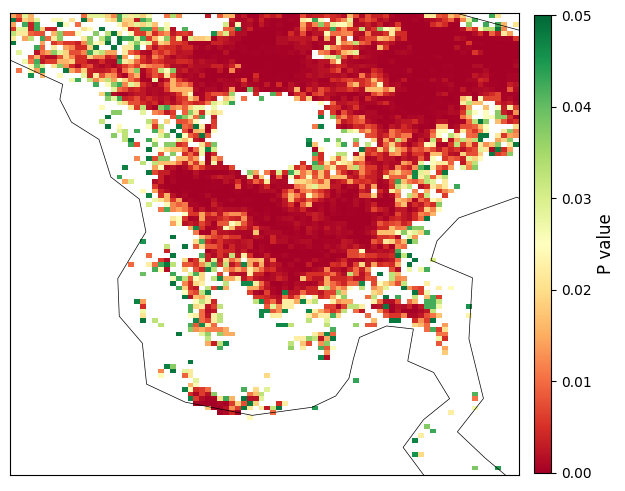

[[        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 [        nan         nan         nan ...         nan         nan
          nan]
 ...
 [-0.05103438         nan -0.03951485 ... -0.01556952         nan
  -0.02185779]
 [-0.03783916 -0.03858352 -0.05091079 ...         nan         nan
          nan]
 [-0.03797039 -0.05033704 -0.04500894 ...         nan         nan
          nan]]


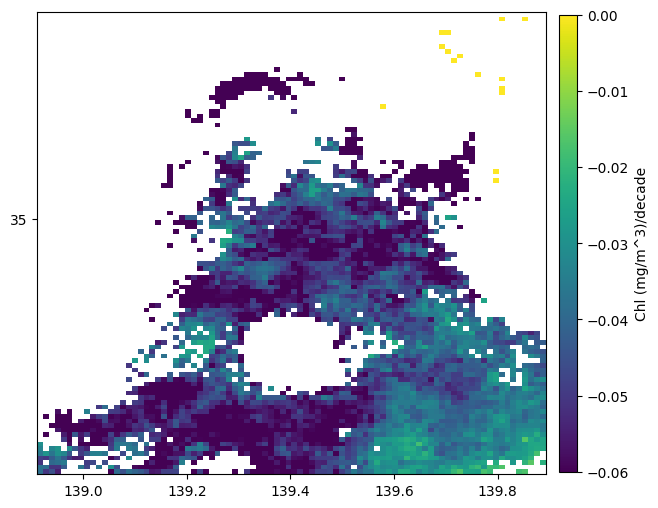

done


In [78]:
print("running")
# compute_trend(time_series_data, "all")
compute_trend(time_series_data_summer, "summer")
# compute_trend(time_series_data_autumn, "autumn")
# compute_trend(time_series_data_winter, "winter")
# compute_trend(time_series_data_spring, "spring")
print("done")

In [79]:
def compute_trend(time_series_data, season):  # Perform Mann-Kendall trend test for each pixel
    trend_results = np.full((len(lat_inds), len(lon_inds)), np.nan)
    p_values = np.full((len(lat_inds), len(lon_inds)), np.nan)
    sen_slopes = np.full((len(lat_inds), len(lon_inds)), np.nan)
    trend = np.full((len(lat_inds), len(lon_inds)), "")
    for (lat_idx, lon_idx), values in time_series_data.items():
        try:
            # Convert list of values to a numpy array
            values = np.array(values)
            valid_values = values[~np.isnan(values)]
        
            # Ensure that values are not all NaNs and there is a sufficient time series length
            if np.count_nonzero(~np.isnan(values)) > 1:  # More than one non-NaN value
                # Perform Mann-Kendall test
                # result = mk.original_test(values[~np.isnan(values)])  # Exclude NaNs for the test
                result = mk.seasonal_test(values[~np.isnan(values)])
                sen_slope = mk.seasonal_sens_slope(valid_values)
                if result.p < 0.05:
                    p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.p
                    trend[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.trend
                    trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = result.slope
                    sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = sen_slope.slope
                else:
                    # Not enough data to perform the test
                    trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
                    p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
                    sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
            else:
                # Not enough data to perform the test
                trend_results[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
                p_values[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
                sen_slopes[lat_idx - lat_inds[0], lon_idx - lon_inds[0]] = np.nan
        except Exception as e:
            continue
    print("finished")
    plot_pvalue(p_values, season)
    # plot_pvalue_significant(p_values, season)
    plot_slope(sen_slopes,season)

In [77]:
def plot_pvalue(p_values, season="all"):
    # Plot the results
    import matplotlib.pyplot as plt
    from mpl_toolkits.basemap import Basemap
    from matplotlib import pyplot as plot, colors
    from matplotlib.colors import LinearSegmentedColormap
    
    print(p_values)
    # Create a Basemap instance
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=lat[lat_inds[0]], urcrnrlat=lat[lat_inds[-1]],
                llcrnrlon=lon[lon_inds[0]], urcrnrlon=lon[lon_inds[-1]])

    # Create a grid of coordinates
    lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
    rgb_colors = ["blue","green","lightgreen", "yellow", "orange", "#FF474C", "red"]
    
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
    extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
    ax.imshow(p_values, cmap='gray',  extent=extent)
    
    # Create a colormap object
    custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)
    
    # mark light blue for values greater than 0.05
    
    # Create a grid of coordinates
    lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
    # rgb_colors = ["red","blue","green","lightgreen", "yellow", "orange"]
    # custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)
    # masked_p_values, custom_colormap = mask_values(p_values, 0.06, "red")
    
    # ims = ax.imshow(masked_p_values, vmin=0, vmax=0.05, cmap=custom_colormap, extent=extent)
    
    # ims = ax.imshow(trend_results,vmin=cmin, vmax=cmax,  extent=extent)
    ims = ax.imshow(p_values,  vmin=0, vmax=0.05,cmap="RdYlGn",  extent=extent)
    
    # # Figure labels
    # ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    # ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))
    
    # # Colourbar
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=26)
    # cbar.set_label('log10(Chl-a) Conc. mg/m^3', fontsize="12")
    cbar.set_label('P value', fontsize="12")
    
    # ticks = [ims.get_clim()[0],0, ims.get_clim()[1]] # This gets the color limit range
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([f'{ticks[0]:.2f}', f'{ticks[1]:.2f}', f'{ticks[2]:.2f}']) # Format as desired
    # plt.savefig(f'results/modis_chla_pvalues2_modified_{season}.png', dpi=300, bbox_inches='tight')

    # crop with shape file
    print("crop with shape file")
    m.readshapefile( 'shapefiles/Untitled-polygon','Untitled-polygon', drawbounds=True)
    # m.drawcoastlines()
    
    # contour
    # m.contourf(lon_grid, lat_grid, p_values, cp=custom_colormap, latlon=True)
    # m.drawcoastlines()
    # m.drawcountries()
    # m.drawstates()
    # m.drawparallels(np.arange(lat_grid.min(), lat_grid.max(), 0.5), labels=[1, 0, 0, 0])
    # m.drawmeridians(np.arange(lon_grid.min(), lon_grid.max(), 0.5), labels=[0, 0, 0, 1])
    
    plt.show()


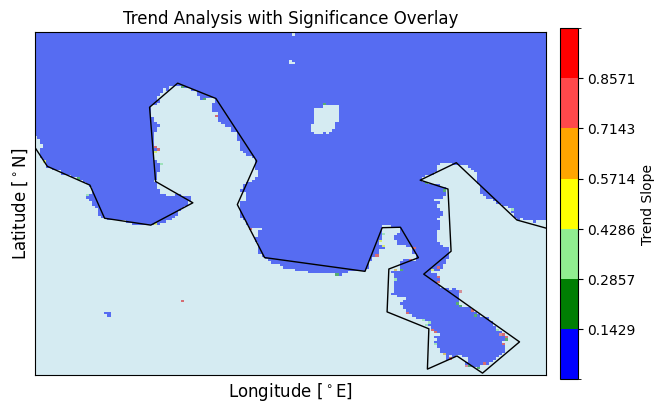

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

# Assuming p_values is your array of p-values
# Assuming trend_results is your array of trend values (e.g., Sen's slope)

# Create a Basemap instance
m = Basemap(projection='cyl', resolution='l',
            llcrnrlat=lat[lat_inds[0]], urcrnrlat=lat[lat_inds[-1]],
            llcrnrlon=lon[lon_inds[0]], urcrnrlon=lon[lon_inds[-1]])

# Create a grid of coordinates
lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])

# Define your colormap for significant trends
rgb_colors = ["blue", "green", "lightgreen", "yellow", "orange", "#FF474C", "red"]
custom_colormap = LinearSegmentedColormap.from_list('custom', rgb_colors)

# Set the bounds for the colormap
bounds = np.linspace(0, 1, len(rgb_colors) + 1)
norm = BoundaryNorm(bounds, custom_colormap.N)

# Plot the trend results with the custom colormap
fig, ax = plt.subplots(figsize=(7, 6))
m.drawcoastlines()
trend_im = m.pcolormesh(lon_grid, lat_grid, trend_results, cmap=custom_colormap, norm=norm, latlon=True)

# Overlay non-significant trends in light blue
# Mask significant trends (p < 0.05), so non-significant trends are shown
non_sig_mask = np.ma.masked_greater(p_values, 0.05).mask
m.pcolormesh(lon_grid, lat_grid, non_sig_mask, cmap=ListedColormap(['lightblue']), alpha=0.5, latlon=True)

# Add color bar
cbar = plt.colorbar(trend_im, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025, spacing='proportional', ticks=bounds[1:-1])
cbar.set_label('Trend Slope')

ax.set_xlabel('Longitude [$^\circ$E]', fontsize="12")
ax.set_ylabel('Latitude [$^\circ$N]', fontsize="12")

plt.title('Trend Analysis with Significance Overlay')
plt.show()


In [7]:
# Plot the results
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plot, colors
from matplotlib.colors import LinearSegmentedColormap


In [57]:
def plot_slope(sen_slopes,season="all"):
    print(sen_slopes)
    # sen_slopes = trend_results
    # sen_slopes = sen_slopes * 12*10
    
    fig, ax = plot.subplots(figsize=(7, 6))  # Adjust the width and height to better suit your data aspect ratio
    lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
    extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]
    # ax.imshow(sen_slopes, cmap='gray', vmin=0, vmax=1, extent=extent)
    
    ims = ax.imshow(sen_slopes , vmin=-0.06, vmax=0, extent=extent)
    
    # # Figure labels
    # ax.set_xlabel('Longitude [$^\mathregular{o}$E]', fontsize="12")
    # ax.set_ylabel('Latitude [$^\mathregular{o}$N]', fontsize="12")
    ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))
    # ax.set_title(time[0].strftime('%b %Y'))
    
    # # Colourbar
    cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025,  aspect=26)
    # cbar.set_label('SST (℃/decade)')
    cbar.set_label('Chl (mg/m^3)/decade')
    
    # Small Sagami Bay
    lat_min, lat_max = 35.124, 35.34
    lon_min, lon_max = 139.115, 139.68
    # plt.savefig(f'results/seasonal_slope_sst_modis{season}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
# def plot_slope(sen_slopes, p_values, season="all"):
#     import numpy as np
#     import matplotlib.pyplot as plt
#     from mpl_toolkits.basemap import Basemap
   
#    # mask p_values of nan to 10
#    #  p_values = np.where(np.isnan(p_values), 10, p_values)
#     # Check if p_values is a numpy array with numeric type, if not, try to convert it
#     if not isinstance(p_values, np.ndarray) or p_values.dtype.type is np.str_:
#         try:
#             p_values = np.array(p_values, dtype=float)
#         except ValueError as e:
#             raise ValueError("p_values must be a numeric array") from e

#     # Mask slopes where p-values are greater than or equal to 0.05
#     masked_sen_slopes = np.ma.masked_where(p_values >= 0.05, sen_slopes*12*10)  # Adjust slope units if necessary

#     # Plotting code (make sure to use masked_sen_slopes instead of sen_slopes directly)
#     fig, ax = plt.subplots(figsize=(7, 6))
#     lon_grid, lat_grid = np.meshgrid(lon[lon_inds], lat[lat_inds])
#     extent = [lon_grid.min(), lon_grid.max(), lat_grid.min(), lat_grid.max()]

#     ims = ax.imshow(masked_sen_slopes, vmin=-2, vmax=0, extent=extent)

#     ax.set_yticks(range(int(np.ceil(lat_grid.min())), int(np.ceil(lat_grid.max())), 1))

#     cbar = fig.colorbar(ims, ax=ax, orientation='vertical', fraction=0.0324, pad=0.025, aspect=26)
#     cbar.set_label('Chl (mg/m^3)/decade')

#     plt.show()
